<a href="https://colab.research.google.com/github/airenare/pneumonia_xray/blob/main/notebooks/02_Modeling_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-Ray CNN to Detect Pneumonia

## Data Processing and Modeling

In [1]:
!pip install --upgrade tensorflow

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

import os

from google.colab import drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
tf.__version__

'2.16.1'

### Importing the Datasets from Kaggle

In [3]:
# !pip install kaggle

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Kaggle json path
kaggle_path = '/content/drive/MyDrive/kaggle.json'

In [6]:
!mkdir ~/.kaggle
!cp {kaggle_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls

drive  sample_data


In [7]:
kaggle_1 = 'paultimothymooney/chest-xray-pneumonia'
kaggle_2 = 'salonimate/covid-pneumonia-nomal-xray'

In [8]:
# # make sure kaggle uses kaggle.json file
# !kaggle config set -n path -v /content/images

# # Download both datasets in the working directory
# !kaggle datasets download -d {kaggle_1}
# !kaggle datasets download -d {kaggle_2}

In [9]:
drive_images_path = 'drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/images'

In [10]:
# Function to get datasets from Kaggle
def get_kaggle_dataset(dataset_name, download_folder,
                       save_to_drive=False, drive_path=None,
                       delete_zip=True, delete_MACOSX=True):
  """
  Downloads a dataset from Kaggle or Google Drive.

  Args:
    dataset_name: The name of the dataset to download.
    download_folder: The folder where the dataset will be downloaded (no trailing /)
    save_to_drive: Whether to save the dataset to Google Drive.
    drive_path: The path to the Google Drive folder where the dataset will be saved.
  """
  # Check if the dataset is already downloaded
  if os.path.exists(f'{download_folder}/{dataset_name}.zip'):
    print(f'Dataset {dataset_name} already downloaded.')
    return

  # Set download folder
  !kaggle config set -n path -v {download_folder}

  # Download the dataset
  !kaggle datasets download -d {dataset_name}

  # Unzip the dataset
  !unzip -q {download_folder}/datasets/{dataset_name}/{dataset_name.split("/")[-1]}.zip -d {download_folder}

  # Save to drive
  if save_to_drive:
    !cp /content/images/datasets/{dataset_name}/{dataset_name.split("/")[-1]}.zip {drive_path}
    print(f'Dataset {dataset_name} saved to Google Drive.')

  # Delete the zip archive
  if delete_zip:
    !rm {download_folder}/{dataset_path.split("/")[-1]}

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX')\
   and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  print(f'Dataset {dataset_name} downloaded and saved.')

In [11]:
# Function to get datasets from Google Drive
def get_drive_dataset(dataset_path, download_folder,
                      delete_zip=True, remove_MACOSX=True):
  """
  Downloads a dataset from Google Drive.

  Args:
    dataset_path: The path to the dataset in Google Drive.
    download_folder: The folder where the dataset will be downloaded (no trailing /)
  """

  # Create download folder if does not exist
  if not os.path.exists(download_folder):
    !mkdir {download_folder}
    print(f'Download folder {download_folder} created.')
  else:
    print(f'Download folder {download_folder} already exists.')

  # Check if the dataset is already downloaded
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-1]}'):
    print(f'Dataset {dataset_path.split("/")[-1]} already downloaded.')
    # Delete zip if still there
    if delete_zip:
      !rm {download_folder}/{dataset_path.split("/")[-1]}
      print(f'Zip archive {dataset_path.split("/")[-1]} removed.')
    # Remove the __MACOSX folder
    if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
      !rm -r {download_folder}/__MACOSX
      print('__MACOSX folder removed.')
    return

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  # Download the dataset and skip if exists
  !cp {dataset_path} {download_folder} --no-clobber
  print(f'Dataset {dataset_path.split("/")[-1]} downloaded.')

  # Unzip the dataset
  !unzip -q {download_folder}/{dataset_path.split("/")[-1]} -d {download_folder}
  print(f'Dataset {dataset_path.split("/")[-1]} unzipped.')

  # Delete the zip archive
  if delete_zip:
    !rm {download_folder}/{dataset_path.split("/")[-1]}
    print(f'Zip archive {dataset_path.split("/")[-1]} removed.')

  # Remove the __MACOSX folder
  if os.path.exists(f'{download_folder}/{dataset_path.split("/")[-2]}/__MACOSX') and remove_MACOSX:
    !rm -r {download_folder}/__MACOSX
    print('__MACOSX folder removed.')

  print(f'Dataset {dataset_path.split("/")[-1]} downloaded and saved.')

In [12]:
!ls {drive_images_path}

chest-xray-pneumonia.zip  covid-pneumonia-nomal-xray.zip


In [13]:
get_drive_dataset(f'{drive_images_path}/chest-xray-pneumonia.zip', '/content/images')

Download folder /content/images created.
Dataset chest-xray-pneumonia.zip downloaded.
Dataset chest-xray-pneumonia.zip unzipped.
Zip archive chest-xray-pneumonia.zip removed.
Dataset chest-xray-pneumonia.zip downloaded and saved.


In [14]:
get_drive_dataset(f'{drive_images_path}/covid-pneumonia-nomal-xray.zip', '/content/images')

Download folder /content/images already exists.
Dataset covid-pneumonia-nomal-xray.zip downloaded.
Dataset covid-pneumonia-nomal-xray.zip unzipped.
Zip archive covid-pneumonia-nomal-xray.zip removed.
Dataset covid-pneumonia-nomal-xray.zip downloaded and saved.


In [15]:
!rm -r /content/images/chest_xray/__MACOSX
!rm -r /content/images/chest_xray/chest_xray

In [50]:
# Remove covid folders
!rm -r /content/images/New-CNP-Dataset/testing/covid
!rm -r /content/images/New-CNP-Dataset/train/covid
!rm -r /content/images/New-CNP-Dataset/validation/covid

### Combine the datasets

In [5]:
# Define the image size and batch size
img_height = 128
img_width = 128
batch_size = 32

In [52]:
ds_1_path = '/content/images/chest_xray'
ds_2_path = '/content/images/New-CNP-Dataset'

In [53]:
train_dir_1 = f"{ds_1_path}/train"
val_dir_1 = f"{ds_1_path}/val"
test_dir_1 = f"{ds_1_path}/test"

train_dir_2 = f"{ds_2_path}/train"
val_dir_2 = f"{ds_2_path}/validation"
test_dir_2 = f"{ds_2_path}/testing"

In [54]:
image_mode = 'grayscale'

# First DS
print("First directory")
train_ds_1 = image_dataset_from_directory(
    train_dir_1,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds_1 = image_dataset_from_directory(
    val_dir_1,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds_1 = image_dataset_from_directory(
    test_dir_1,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size)

# Second DS
print("Second directory")
train_ds_2 = image_dataset_from_directory(
    train_dir_2,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds_2 = image_dataset_from_directory(
    val_dir_2,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds_2 = image_dataset_from_directory(
    test_dir_2,
    color_mode= image_mode,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    )

First directory
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Second directory
Found 3010 files belonging to 2 classes.
Found 692 files belonging to 2 classes.
Found 924 files belonging to 2 classes.


In [55]:
# Get the class names
class_names_1 = {i: train_ds_1.class_names[i] for i in range(len(train_ds_1.class_names))}
# Get the class names
class_names_2 = {i: train_ds_2.class_names[i] for i in range(len(train_ds_2.class_names))}

class_names_1, class_names_2

({0: 'NORMAL', 1: 'PNEUMONIA'}, {0: 'normal', 1: 'pneumonia'})

In [56]:
# Function to preview images from dataset
def preview_images(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
      for i in range(9):
          plt.subplot(3,3, i + 1)
          plt.imshow(np.squeeze(images[i].numpy().astype('uint8')), cmap='gray')
          plt.title(dataset.class_names[labels[i]])
          plt.axis("off")

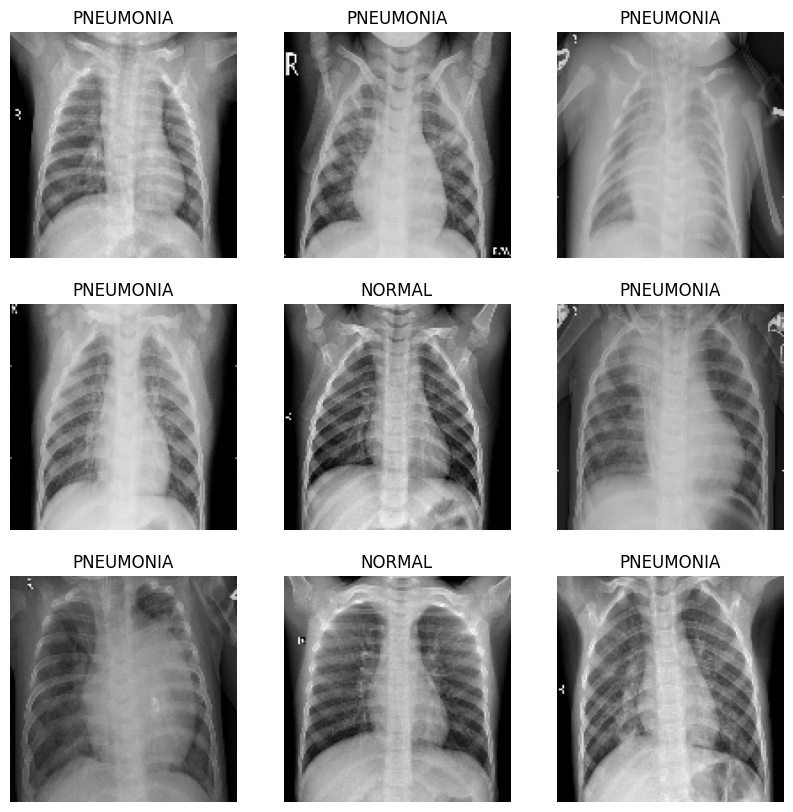

In [57]:
preview_images(train_ds_1)

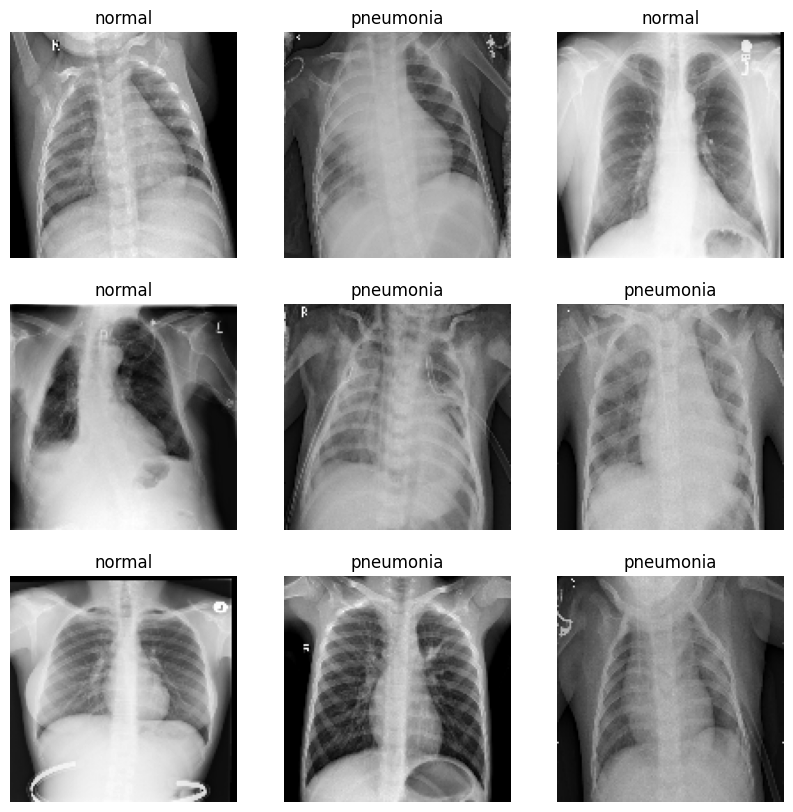

In [59]:
preview_images(train_ds_2)

In [60]:
# Get shape of images in train_ds_1
for image_batch, labels_batch in train_ds_1.take(1):
  print(image_batch.shape)

for image_batch, labels_batch in train_ds_2.take(1):
  print(image_batch.shape)

(32, 128, 128, 1)
(32, 128, 128, 1)


In [10]:
# Function to show the number of images for each category within a dataset
def show_num_images(dataset, directory):
  classes = dataset.class_names
  num_images_per_class = []
  for cls in classes:
    num_images_per_class.append(len(os.listdir(f"{directory}/{cls}")))
  df = pd.DataFrame({'Class': classes, 'Number of Images': num_images_per_class})
  print(df)
  sns.barplot(x='Class', y='Number of Images', data=df)
  plt.show()
  return df

       Class  Number of Images
0     NORMAL              1341
1  PNEUMONIA              3875


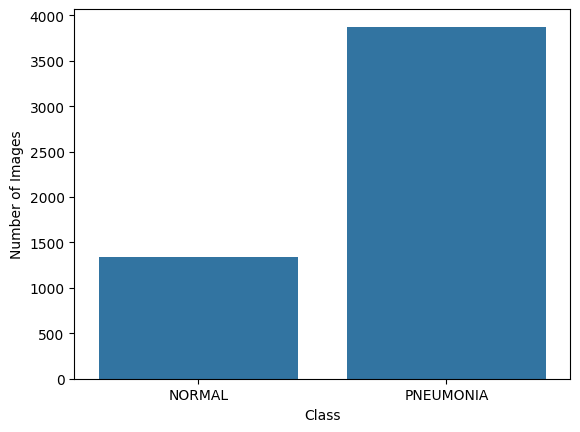

,Class,Number of Images
0,NORMAL,1341
1,PNEUMONIA,3875


In [62]:
show_num_images(train_ds_1, train_dir_1)

       Class  Number of Images
0     normal              1505
1  pneumonia              1505


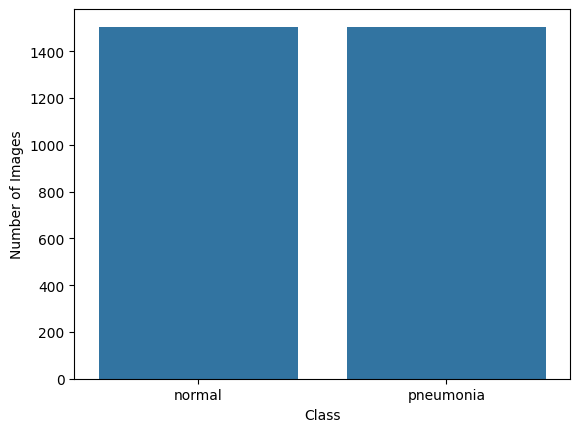

,Class,Number of Images
0,normal,1505
1,pneumonia,1505


In [63]:
show_num_images(train_ds_2, train_dir_2)

In [64]:
# Create a new directory 'combined' in /content/images folder and copy the contents of /content/images/chest_xray
!mkdir /content/images/combined
!cp -r /content/images/chest_xray/test /content/images/combined
!cp -r /content/images/chest_xray/train /content/images/combined
!cp -r /content/images/chest_xray/val /content/images/combined

In [65]:
# Copy the contents of /content/images/New-CNP-Dataset/train/normal folder into the /content/images/combined/train/NORMAL
!cp -r /content/images/New-CNP-Dataset/train/normal/* /content/images/combined/train/NORMAL

In [6]:
ds_path = '/content/images/combined'

In [7]:
train_dir = f"{ds_path}/train"
val_dir = f"{ds_path}/val"
test_dir = f"{ds_path}/test"

In [15]:
# Create the new datasets
train_ds = image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

test_ds = image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 6503 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


       Class  Number of Images
0     NORMAL              2628
1  PNEUMONIA              3875


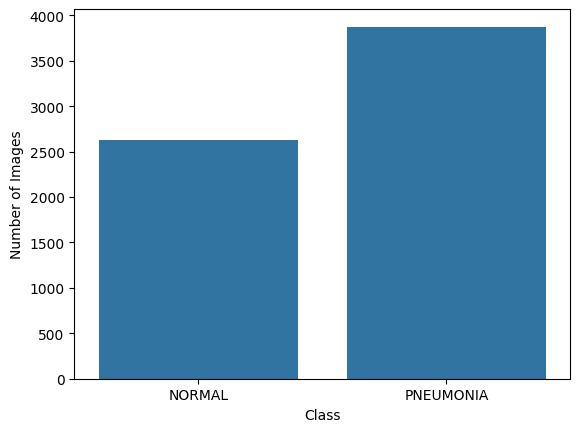

,Class,Number of Images
0,NORMAL,2628
1,PNEUMONIA,3875


In [11]:
class_df = show_num_images(train_ds, train_dir)
class_df.head()

This looks much better than before. Let's get the class weights now.

In [12]:
# Add the class_weight column to the class_df
class_df['class_weight'] = class_df['Number of Images'] / class_df['Number of Images'].sum()
class_df

,Class,Number of Images,class_weight
0,NORMAL,2628,0.404121
1,PNEUMONIA,3875,0.595879


### Modeling

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [16]:
model = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

In [17]:
class_weights = {0: class_df['class_weight'][0], 1: class_df['class_weight'][1]}
class_weights

{0: 0.4041211748423804, 1: 0.5958788251576196}

In [18]:
optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
    run_eagerly=True
)

In [19]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights
)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 29s 121ms/step - accuracy: 0.6465 - loss: 0.8147 - val_accuracy: 0.6250 - val_loss: 1.0140
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8021 - loss: 0.2121 - val_accuracy: 0.7500 - val_loss: 0.6634
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8360 - loss: 0.1833 - val_accuracy: 0.6250 - val_loss: 0.8137
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.8406 - loss: 0.1748 - val_accuracy: 0.7500 - val_loss: 0.7054
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.8374 - loss: 0.1705 - val_accuracy: 0.6875 - val_loss: 0.7685
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.8613 - loss: 0.1626 - val_accuracy: 0.7500 - val_loss: 0.8239
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.8622 - loss: 0.1649 - val_accuracy: 0.6875 - val_loss: 0.8757
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.8791 - loss: 0

In [20]:
# Function to plot training history
def plot_history(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

In [21]:
# Function to show the confusion matrix
def show_cm(model):
    # Define class names
    class_names = ['NORMAL', 'PNEUMONIA']

    # List to store true and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset and make predictions
    for images, labels in test_ds:
        # Make predictions
        predictions = model.predict(images)
        # Get predicted labels
        predicted_labels.extend(np.argmax(predictions, axis=1))
        # Get true labels
        true_labels.extend(labels.numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

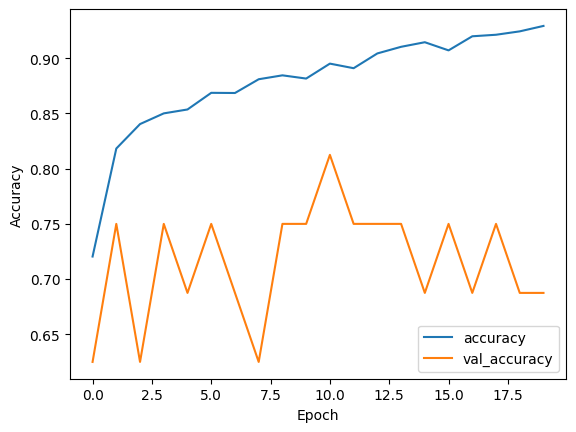

In [22]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


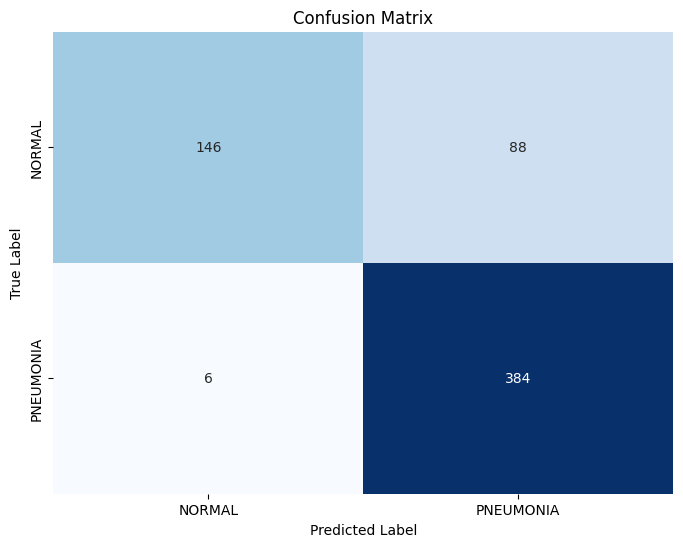

In [23]:
show_cm(model)

In [24]:
# Accuracy of model
model.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8523 - loss: 0.5082


[0.4741751253604889, 0.8493589758872986]

## Model_1 testing


In [25]:
# Test image directory
test_path = '/content/images/chest_xray/test'

# Create a dataframe with filenames of all images in the dataset in the first column and labels in the second
test_df = pd.DataFrame(columns=['filename', 'label'])

for subdir, dirs, files in os.walk(test_path):
    for file in files:
        # Get the label from the subdirectory name
        label = subdir.split(os.path.sep)[-1]
        # Add the filename and label to the dataframe
        test_df = pd.concat([test_df, pd.DataFrame({'filename': os.path.join(subdir, file), 'label': label}, index=[0])], ignore_index=True)

# Convert PNEUMONIA to 1 and NORMAL to 0 in label column
# test_df['label'] = test_df['label'].apply(lambda x: 1 if x == 'PNEUMONIA' else 0)
# test_df.head()

In [26]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=(128, 128))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

In [27]:
def predict_image(image_path, model):
    img = preprocess_image(image_path)
    pred = model.predict(img)
    class_names = ['NORMAL', 'PNEUMONIA']
    return class_names[np.argmax(pred)]

In [28]:
# Single image test
# Load the image
img_path = '/content/images/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'

# Make prediction
predicted_class = predict_image(img_path, model)

# Print the prediction
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted class: PNEUMONIA


In [29]:
# Iterate through the filename column of test_df and feed image paths to predict_image function, add result to the new column
test_df['prediction'] = test_df['filename'].apply(lambda x: predict_image(x, model))
test_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

,filename,label,prediction
0,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA
1,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA
2,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA
3,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA
4,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA


In [30]:
# Calculate accuracy, recall, precision and f1 score

accuracy = accuracy_score(test_df['label'], test_df['prediction'])
recall = recall_score(test_df['label'], test_df['prediction'], average='macro')
precision = precision_score(test_df['label'], test_df['prediction'], average='macro')
f1_score_macro = f1_score(test_df['label'], test_df['prediction'], average='macro')
f1_score_micro = f1_score(test_df['label'], test_df['prediction'], average='micro')
f1_score_weighted = f1_score(test_df['label'], test_df['prediction'], average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score (Macro): {f1_score_macro:.2f}")
print(f"F1 Score (Micro): {f1_score_micro:.2f}")
print(f"F1 Score (Weighted): {f1_score_weighted:.2f}")


Accuracy: 0.85
Recall: 0.80
Precision: 0.89
F1 Score (Macro): 0.82
F1 Score (Micro): 0.85
F1 Score (Weighted): 0.84


## Save Model_final

In [32]:
# Save model, json and weights
!mkdir model_final

model.save('model_final/model_final_1.keras')

model_json = model.to_json()
with open("model_final/model_final_1.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("model_final/model_final_1.weights.h5")

print("Saved model to disk!")


mkdir: cannot create directory ‘model_final’: File exists
Saved model to disk!


In [120]:
# Load model and run test again
loaded_model = tf.keras.models.load_model('model_final/model_final.keras')

In [121]:
loaded_model.evaluate(test_ds)

20/20 [==============================] - 0s 18ms/step - loss: 0.4137 - accuracy: 0.8317


[0.41371163725852966, 0.8317307829856873]

In [122]:
test_df['prediction_loaded'] = test_df['filename'].apply(lambda x: predict_image(x, loaded_model))
test_df.head()

1/1 [==============================] - 0s 23ms/step


,filename,label,prediction,prediction_loaded
0,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA,PNEUMONIA
1,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA,PNEUMONIA
2,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA,PNEUMONIA
3,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA,PNEUMONIA
4,/content/images/chest_xray/test/PNEUMONIA/pers...,PNEUMONIA,PNEUMONIA,PNEUMONIA


In [124]:
# Check if prediction == prediction_loaded
(test_df['prediction'] == test_df['prediction_loaded']).value_counts()


True    624
Name: count, dtype: int64

In [125]:
# Zip the model_final folder
!zip -r model_final.zip model_final

# Upload the zip file to Google Drive
!cp model_final.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_final.zip

print("Saved to drive")

  adding: model_final/ (stored 0%)
  adding: model_final/model_final_weights.h5 (deflated 8%)
  adding: model_final/model_final.keras (deflated 28%)
  adding: model_final/model_final.json (deflated 88%)
Saved to drive


In [127]:
model.save('model_final/model_final', save_format='tf')

In [128]:
!zip -r model_final_tf.zip model_final/model_final

  adding: model_final/model_final/ (stored 0%)
  adding: model_final/model_final/variables/ (stored 0%)
  adding: model_final/model_final/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: model_final/model_final/variables/variables.index (deflated 65%)
  adding: model_final/model_final/fingerprint.pb (stored 0%)
  adding: model_final/model_final/assets/ (stored 0%)
  adding: model_final/model_final/saved_model.pb (deflated 88%)
  adding: model_final/model_final/keras_metadata.pb (deflated 91%)


In [129]:
!cp model_final_tf.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_final_tf.zip
print("Saved to drive")

Saved to drive


In [33]:
!mkdir model_final_1
!cp model_final/model_final_1.keras model_final_1/
!cp model_final/model_final_1.json model_final_1/
!cp model_final/model_final_1.weights.h5 model_final_1/

!zip -r model_final_1.zip model_final_1
!cp model_final_1.zip /content/drive/MyDrive/Springboard/SPRINGBOARD\ -\ Final\ Capstone\ Project/model_final_1.zip
print("Saved to drive")

  adding: model_final_1/ (stored 0%)
  adding: model_final_1/model_final_1.weights.h5 (deflated 13%)
  adding: model_final_1/model_final_1.json (deflated 85%)
  adding: model_final_1/model_final_1.keras (deflated 13%)
Saved to drive


# Summary
Final model is saved and will be called locally via the UI.

In [126]:
# tf version
tf.__version__

'2.15.0'

In [130]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    F